In [65]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Load data and come up with first iteration of keywords

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


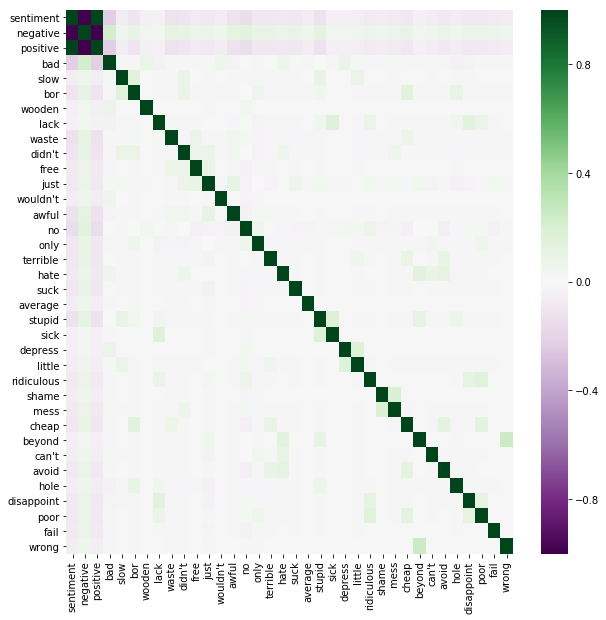

In [2]:
imdb = pd.read_table('./sentiment labelled sentences/imdb_labelled.txt', header=None, quoting=3)
imdb.columns = ['review', 'sentiment']
imdb['negative'] = (imdb['sentiment'] == 0)
imdb['positive'] = (imdb['sentiment'] == 1)

## Guess keywords (features) which might turn up in bad reviews

keywords_bad = ['bad', 'slow', 'bor', 'wooden', 'lack', 
                'waste', "didn't", 'free', 'just', "wouldn't", 
                'awful', 'no', 'only', 'terrible',
                'hate', 'suck', 'average', 'stupid',
                'sick', 'depress', 'little', 'ridiculous', 'shame',
                ' mess', 'cheap', 'beyond', "can't", 'avoid', 'hole',
                'disappoint', 'poor', 'fail', 'wrong']

for key in keywords_bad:
    imdb[str(key)] = imdb.review.str.contains(
        str(key), 
        case=False
    )

plt.figure(figsize=(10, 10))
sns.heatmap(imdb.corr(), cmap='PRGn')
plt.show()

### First iteration - creation and evaluation

In [3]:
data_bad = imdb[keywords_bad]
target_bad = imdb['negative']

from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

bnb.fit(data_bad, target_bad)

y_pred = bnb.predict(data_bad)

print("Number of mislabeled points out of a total {} points : {}".format(
    data_bad.shape[0],
    (target_bad != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 255


In [10]:
## Test using holdout method

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_bad, target_bad, test_size=0.3, random_state=34)

print("Holdout method accuracy: " + str(bnb.fit(x_train, y_train).score(x_test, y_test)))
print("Same dataset accuracy: " + str(bnb.fit(data_bad, target_bad).score(data_bad, target_bad)))
print("Predict all bad: " + str(sum(np.full(len(target_bad), True, dtype=bool) == target_bad)/len(target_bad)))

Holdout method accuracy: 0.72
Same dataset accuracy: 0.745
Predict all bad: 0.5


In [12]:
from sklearn.model_selection import cross_val_score
cv_accuracies = cross_val_score(bnb, data_bad, target_bad, cv=10)
print("Cross validation mean accuracy: " + str(np.mean(cv_accuracies)))

Cross validation mean accuracy: 0.7150000000000001


In [28]:
## Cross validation model

slice_size = round(len(data_bad) / 10, 0)

accuracies = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
confusion_matrix = []
sensitivities = []
specificities = []

for i in np.arange(1, 11):
    x_test = data_bad.loc[(i-1)*slice_size: min(i*slice_size, len(data_bad)), ]
    y_test = target_bad.loc[(i-1)*slice_size: min(i*slice_size, len(target_bad)), ]
    x_train = data_bad.loc[~data_bad.index.isin(x_test.index),]
    y_train = target_bad.loc[~target_bad.index.isin(x_test.index),]
    y_pred = bnb.fit(x_train, y_train).predict(x_test)
    
    accuracies.append(sum(y_test == y_pred))
    true_positives.append(sum((y_test == y_pred) & (y_pred == True)))
    false_positives.append(sum((y_test != y_pred) & (y_pred == True)))
    true_negatives.append(sum((y_test == y_pred) & (y_pred == False)))
    false_negatives.append(sum((y_test != y_pred) & (y_pred == False)))
    
    confusion_matrix.append([[true_positives[i-1], false_negatives[i-1]], [false_positives[i-1], true_negatives[i-1]]])
    sensitivities.append(true_positives[i-1]/(true_positives[i-1] + false_negatives[i-1]))
    specificities.append(true_negatives[i-1]/(true_negatives[i-1] + false_positives[i-1]))

In [29]:
confusion_matrix

[[[18, 21], [7, 55]],
 [[34, 46], [2, 19]],
 [[30, 25], [10, 36]],
 [[26, 14], [9, 52]],
 [[33, 23], [3, 42]],
 [[38, 35], [3, 25]],
 [[23, 10], [11, 57]],
 [[15, 26], [3, 57]],
 [[35, 19], [14, 33]],
 [[24, 9], [13, 54]]]

In [36]:
print("Sensitivities: " + str(sensitivities))
print("Mean sensitivity: " + str(np.mean(sensitivities)))

Sensitivities: [0.46153846153846156, 0.425, 0.5454545454545454, 0.65, 0.5892857142857143, 0.5205479452054794, 0.696969696969697, 0.36585365853658536, 0.6481481481481481, 0.7272727272727273]
Mean sensitivity: 0.5630070897411359


In [37]:
print("Specificities: " + str(specificities))
print("Mean specificity: " + str(np.mean(specificities)))

Specificities: [0.8870967741935484, 0.9047619047619048, 0.782608695652174, 0.8524590163934426, 0.9333333333333333, 0.8928571428571429, 0.8382352941176471, 0.95, 0.7021276595744681, 0.8059701492537313]
Mean specificity: 0.8549449970137392


In [38]:
print("Mean true positives: " + str(np.mean(true_positives)))
print("Mean false positives: " + str(np.mean(false_positives)))
print("Mean true negatives: " + str(np.mean(true_negatives)))
print("Mean false negatives: " + str(np.mean(false_negatives)))

Mean true positives: 27.6
Mean false positives: 7.5
Mean true negatives: 43.0
Mean false negatives: 22.8


In [39]:
## Most errors (22.8% of reviews) are false negatives - i.e. the 
## model considers them good reviews when actually they are bad.
## By contrast only 7.5% of reviews are classifed as bad when
## they are actually good.

## This is also seen because the sensitivity is lower than the 
## specificity.

## Suggests worth thinking of more keywords.

### Second iteration - creation and evaluation

In [40]:
imdb = pd.read_table('./sentiment labelled sentences/imdb_labelled.txt', header=None, quoting=3)
imdb.columns = ['review', 'sentiment']
imdb['negative'] = (imdb['sentiment'] == 0)
imdb['positive'] = (imdb['sentiment'] == 1)

## Guess keywords (features) which might turn up in bad reviews

keywords_bad = ['bad', 'slow', 'bor', 'wooden', 'lack', 
                'waste', "didn't", 'free', 'just', "wouldn't", 
                'awful', 'no', 'only', 'terrible',
                'hate', 'suck', 'average', 'stupid',
                'sick', 'depress', 'little', 'ridiculous', 'shame',
                ' mess', 'cheap', 'beyond', "can't", 'avoid', 'hole',
                'disappoint', 'poor', 'fail', 'wrong', 'weak', 'wors']

for key in keywords_bad:
    imdb[str(key)] = imdb.review.str.contains(
        str(key), 
        case=False
    )

data_bad = imdb[keywords_bad]
target_bad = imdb['negative']
    
bnb = BernoulliNB()

bnb.fit(data_bad, target_bad)

y_pred = bnb.predict(data_bad)

print("Number of mislabeled points out of a total {} points : {}".format(
    data_bad.shape[0],
    (target_bad != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 262


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [41]:
## Cross validation model

slice_size = round(len(data_bad) / 10, 0)

accuracies = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
confusion_matrix = []
sensitivities = []
specificities = []

for i in np.arange(1, 11):
    x_test = data_bad.loc[(i-1)*slice_size: min(i*slice_size, len(data_bad)), ]
    y_test = target_bad.loc[(i-1)*slice_size: min(i*slice_size, len(target_bad)), ]
    x_train = data_bad.loc[~data_bad.index.isin(x_test.index),]
    y_train = target_bad.loc[~target_bad.index.isin(x_test.index),]
    y_pred = bnb.fit(x_train, y_train).predict(x_test)
    
    accuracies.append(sum(y_test == y_pred))
    true_positives.append(sum((y_test == y_pred) & (y_pred == True)))
    false_positives.append(sum((y_test != y_pred) & (y_pred == True)))
    true_negatives.append(sum((y_test == y_pred) & (y_pred == False)))
    false_negatives.append(sum((y_test != y_pred) & (y_pred == False)))
    
    confusion_matrix.append([[true_positives[i-1], false_negatives[i-1]], [false_positives[i-1], true_negatives[i-1]]])
    sensitivities.append(true_positives[i-1]/(true_positives[i-1] + false_negatives[i-1]))
    specificities.append(true_negatives[i-1]/(true_negatives[i-1] + false_positives[i-1]))

In [42]:
confusion_matrix

[[[18, 21], [7, 55]],
 [[36, 44], [2, 19]],
 [[29, 26], [4, 42]],
 [[26, 14], [10, 51]],
 [[34, 22], [3, 42]],
 [[40, 33], [3, 25]],
 [[18, 15], [4, 64]],
 [[15, 26], [3, 57]],
 [[41, 13], [13, 34]],
 [[24, 9], [13, 54]]]

In [43]:
print("Sensitivities: " + str(sensitivities))
print("Mean sensitivity: " + str(np.mean(sensitivities)))

Sensitivities: [0.46153846153846156, 0.45, 0.5272727272727272, 0.65, 0.6071428571428571, 0.547945205479452, 0.5454545454545454, 0.36585365853658536, 0.7592592592592593, 0.7272727272727273]
Mean sensitivity: 0.5641739441956616


In [44]:
print("Specificities: " + str(specificities))
print("Mean specificity: " + str(np.mean(specificities)))

Specificities: [0.8870967741935484, 0.9047619047619048, 0.9130434782608695, 0.8360655737704918, 0.9333333333333333, 0.8928571428571429, 0.9411764705882353, 0.95, 0.723404255319149, 0.8059701492537313]
Mean specificity: 0.8787709082338406


In [45]:
print("Mean true positives: " + str(np.mean(true_positives)))
print("Mean false positives: " + str(np.mean(false_positives)))
print("Mean true negatives: " + str(np.mean(true_negatives)))
print("Mean false negatives: " + str(np.mean(false_negatives)))

Mean true positives: 28.1
Mean false positives: 6.2
Mean true negatives: 44.3
Mean false negatives: 22.3


In [46]:
## Overall this model mislabels more points but when cross-validation
## is used it scores slightly better than the previous iteration.

### Third iteration - creation and evaluation

In [54]:
imdb = pd.read_table('./sentiment labelled sentences/imdb_labelled.txt', header=None, quoting=3)
imdb.columns = ['review', 'sentiment']
imdb['negative'] = (imdb['sentiment'] == 0)
imdb['positive'] = (imdb['sentiment'] == 1)

## Guess keywords (features) which might turn up in bad reviews

keywords_bad = ['bad', 'slow', 'bor', 'wooden', 'lack', 
                'waste', "didn't", 'free', 'just', "wouldn't", 
                'awful', 'no', 'only', 'terrible',
                'hate', 'suck', 'average', 'stupid',
                'sick', 'depress', 'little', 'ridiculous', 'shame',
                ' mess', 'cheap', 'beyond', "can't", 'avoid', 'hole',
                'disappoint', 'poor', 'fail', 'wrong', 'weak', 'wors',
                'shame', "isn't", 'unpleasant', 'never']

for key in keywords_bad:
    imdb[str(key)] = imdb.review.str.contains(
        str(key), 
        case=False
    )

data_bad = imdb[keywords_bad]
target_bad = imdb['negative']
    
bnb = BernoulliNB()

bnb.fit(data_bad, target_bad)

y_pred = bnb.predict(data_bad)

print("Number of mislabeled points out of a total {} points : {}".format(
    data_bad.shape[0],
    (target_bad != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 262


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [55]:
## Cross validation model

slice_size = round(len(data_bad) / 10, 0)

accuracies = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
confusion_matrix = []
sensitivities = []
specificities = []

for i in np.arange(1, 11):
    x_test = data_bad.loc[(i-1)*slice_size: min(i*slice_size, len(data_bad)), ]
    y_test = target_bad.loc[(i-1)*slice_size: min(i*slice_size, len(target_bad)), ]
    x_train = data_bad.loc[~data_bad.index.isin(x_test.index),]
    y_train = target_bad.loc[~target_bad.index.isin(x_test.index),]
    y_pred = bnb.fit(x_train, y_train).predict(x_test)
    
    accuracies.append(sum(y_test == y_pred))
    true_positives.append(sum((y_test == y_pred) & (y_pred == True)))
    false_positives.append(sum((y_test != y_pred) & (y_pred == True)))
    true_negatives.append(sum((y_test == y_pred) & (y_pred == False)))
    false_negatives.append(sum((y_test != y_pred) & (y_pred == False)))
    
    confusion_matrix.append([[true_positives[i-1], false_negatives[i-1]], [false_positives[i-1], true_negatives[i-1]]])
    sensitivities.append(true_positives[i-1]/(true_positives[i-1] + false_negatives[i-1]))
    specificities.append(true_negatives[i-1]/(true_negatives[i-1] + false_positives[i-1]))

In [56]:
confusion_matrix

[[[18, 21], [7, 55]],
 [[36, 44], [2, 19]],
 [[30, 25], [4, 42]],
 [[26, 14], [9, 52]],
 [[34, 22], [3, 42]],
 [[40, 33], [3, 25]],
 [[18, 15], [4, 64]],
 [[15, 26], [3, 57]],
 [[40, 14], [13, 34]],
 [[23, 10], [13, 54]]]

In [57]:
print("Sensitivities: " + str(sensitivities))
print("Mean sensitivity: " + str(np.mean(sensitivities)))

Sensitivities: [0.46153846153846156, 0.45, 0.5454545454545454, 0.65, 0.6071428571428571, 0.547945205479452, 0.5454545454545454, 0.36585365853658536, 0.7407407407407407, 0.696969696969697]
Mean sensitivity: 0.5611099711316885


In [58]:
print("Specificities: " + str(specificities))
print("Mean specificity: " + str(np.mean(specificities)))

Specificities: [0.8870967741935484, 0.9047619047619048, 0.9130434782608695, 0.8524590163934426, 0.9333333333333333, 0.8928571428571429, 0.9411764705882353, 0.95, 0.723404255319149, 0.8059701492537313]
Mean specificity: 0.8804102524961357


In [59]:
print("Mean true positives: " + str(np.mean(true_positives)))
print("Mean false positives: " + str(np.mean(false_positives)))
print("Mean true negatives: " + str(np.mean(true_negatives)))
print("Mean false negatives: " + str(np.mean(false_negatives)))

Mean true positives: 28.0
Mean false positives: 6.1
Mean true negatives: 44.4
Mean false negatives: 22.4


### Word cloud for inspiration

In [62]:
imdb_bad = imdb.loc[imdb.sentiment == 0, ]

In [63]:
text = " ".join(review for review in imdb_bad.review)

In [64]:
print("There are {} words in the combination of all bad reviews.".format(len(text)))

There are 39043 words in the combination of all bad reviews.


In [68]:
stopwords = set(STOPWORDS)
stopwords.update(['movie', 'film', 'character', 'acting', 'script',
                 'line', 'scene'])

In [82]:
wordcloud = WordCloud(stopwords=stopwords, background_color='black').generate(text)

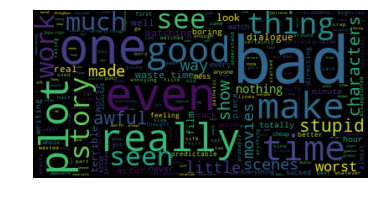

In [83]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [73]:
imdb_good = imdb.loc[imdb.sentiment == 1, ]
text_good = " ".join(review for review in imdb_good.review)

In [74]:
wordcloud_good = WordCloud(stopwords=stopwords, background_color='white').generate(text_good)

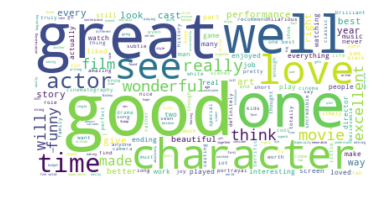

In [75]:
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.show()

### Consider length of review as indicator

In [105]:
imdb_bad['review_length'] = imdb_bad['review'].astype(str).map(len)
np.mean(imdb_bad.review_length)

77.088

In [106]:
imdb_good['review_length'] = imdb_good['review'].astype(str).map(len)
np.mean(imdb_good.review_length)

87.456

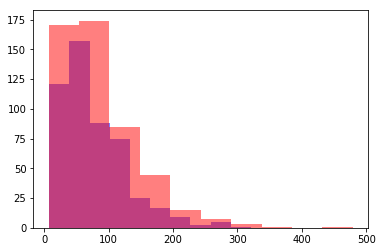

In [110]:
plt.hist(imdb_bad['review_length'], alpha=.5, color='blue')
plt.hist(imdb_good['review_length'], alpha=0.5, color='red')
plt.show()

### Iteration 4 - creation and evaluation

In [76]:
imdb = pd.read_table('./sentiment labelled sentences/imdb_labelled.txt', header=None, quoting=3)
imdb.columns = ['review', 'sentiment']
imdb['negative'] = (imdb['sentiment'] == 0)
imdb['positive'] = (imdb['sentiment'] == 1)

## Guess keywords (features) which might turn up in bad reviews

keywords_bad = ['bad', 'slow', 'bor', 'wooden', 'lack', 
                'waste', "didn't", 'free', 'just', "wouldn't", 
                'awful', 'no', 'only', 'terrible',
                'hate', 'suck', 'average', 'stupid',
                'sick', 'depress', 'little', 'ridiculous', 'shame',
                ' mess', 'cheap', 'beyond', "can't", 'avoid', 'hole',
                'disappoint', 'poor', 'fail', 'wrong', 'weak', 'wors',
                'shame', "isn't", 'unpleasant', 'never', 'even',
                'make']

for key in keywords_bad:
    imdb[str(key)] = imdb.review.str.contains(
        str(key), 
        case=False
    )

data_bad = imdb[keywords_bad]
target_bad = imdb['negative']
    
bnb = BernoulliNB()

bnb.fit(data_bad, target_bad)

y_pred = bnb.predict(data_bad)

print("Number of mislabeled points out of a total {} points : {}".format(
    data_bad.shape[0],
    (target_bad != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 258


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [77]:
## Cross validation model

slice_size = round(len(data_bad) / 10, 0)

accuracies = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
confusion_matrix = []
sensitivities = []
specificities = []

for i in np.arange(1, 11):
    x_test = data_bad.loc[(i-1)*slice_size: min(i*slice_size, len(data_bad)), ]
    y_test = target_bad.loc[(i-1)*slice_size: min(i*slice_size, len(target_bad)), ]
    x_train = data_bad.loc[~data_bad.index.isin(x_test.index),]
    y_train = target_bad.loc[~target_bad.index.isin(x_test.index),]
    y_pred = bnb.fit(x_train, y_train).predict(x_test)
    
    accuracies.append(sum(y_test == y_pred))
    true_positives.append(sum((y_test == y_pred) & (y_pred == True)))
    false_positives.append(sum((y_test != y_pred) & (y_pred == True)))
    true_negatives.append(sum((y_test == y_pred) & (y_pred == False)))
    false_negatives.append(sum((y_test != y_pred) & (y_pred == False)))
    
    confusion_matrix.append([[true_positives[i-1], false_negatives[i-1]], [false_positives[i-1], true_negatives[i-1]]])
    sensitivities.append(true_positives[i-1]/(true_positives[i-1] + false_negatives[i-1]))
    specificities.append(true_negatives[i-1]/(true_negatives[i-1] + false_positives[i-1]))

In [78]:
confusion_matrix

[[[19, 20], [7, 55]],
 [[41, 39], [2, 19]],
 [[32, 23], [6, 40]],
 [[22, 18], [4, 57]],
 [[36, 20], [3, 42]],
 [[41, 32], [5, 23]],
 [[19, 14], [5, 63]],
 [[15, 26], [5, 55]],
 [[35, 19], [9, 38]],
 [[24, 9], [14, 53]]]

In [79]:
print("Sensitivities: " + str(sensitivities))
print("Mean sensitivity: " + str(np.mean(sensitivities)))

Sensitivities: [0.48717948717948717, 0.5125, 0.5818181818181818, 0.55, 0.6428571428571429, 0.5616438356164384, 0.5757575757575758, 0.36585365853658536, 0.6481481481481481, 0.7272727272727273]
Mean sensitivity: 0.5653030757186287


In [80]:
print("Specificities: " + str(specificities))
print("Mean specificity: " + str(np.mean(specificities)))

Specificities: [0.8870967741935484, 0.9047619047619048, 0.8695652173913043, 0.9344262295081968, 0.9333333333333333, 0.8214285714285714, 0.9264705882352942, 0.9166666666666666, 0.8085106382978723, 0.7910447761194029]
Mean specificity: 0.8793304699936094


In [81]:
print("Mean true positives: " + str(np.mean(true_positives)))
print("Mean false positives: " + str(np.mean(false_positives)))
print("Mean true negatives: " + str(np.mean(true_negatives)))
print("Mean false negatives: " + str(np.mean(false_negatives)))

Mean true positives: 28.4
Mean false positives: 6.0
Mean true negatives: 44.5
Mean false negatives: 22.0


### Iteration 5 - creation and evaluation

In [90]:
imdb = pd.read_table('./sentiment labelled sentences/imdb_labelled.txt', header=None, quoting=3)
imdb.columns = ['review', 'sentiment']
imdb['negative'] = (imdb['sentiment'] == 0)
imdb['positive'] = (imdb['sentiment'] == 1)

## Guess keywords (features) which might turn up in bad reviews

keywords_bad = ['bad', 'slow', 'bor', 'wooden', 'lack', 
                'waste', "didn't", 'free', 'just', "wouldn't", 
                'awful', 'no', 'only', 'terrible',
                'hate', 'suck', 'average', 'stupid',
                'sick', 'depress', 'little', 'ridiculous', 'shame',
                ' mess', 'cheap', 'beyond', "can't", 'avoid', 'hole',
                'disappoint', 'poor', 'fail', 'wrong', 'weak', 'wors',
                'shame', "isn't", 'unpleasant', 'never', 'even',
                'make', 'work', 'plot', 'thing']

for key in keywords_bad:
    imdb[str(key)] = imdb.review.str.contains(
        str(key), 
        case=False
    )

data_bad = imdb[keywords_bad]
target_bad = imdb['negative']
    
bnb = BernoulliNB()

bnb.fit(data_bad, target_bad)

y_pred = bnb.predict(data_bad)

print("Number of mislabeled points out of a total {} points : {}".format(
    data_bad.shape[0],
    (target_bad != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 246


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [91]:
## Cross validation model

slice_size = round(len(data_bad) / 10, 0)

accuracies = []
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
confusion_matrix = []
sensitivities = []
specificities = []

for i in np.arange(1, 11):
    x_test = data_bad.loc[(i-1)*slice_size: min(i*slice_size, len(data_bad)), ]
    y_test = target_bad.loc[(i-1)*slice_size: min(i*slice_size, len(target_bad)), ]
    x_train = data_bad.loc[~data_bad.index.isin(x_test.index),]
    y_train = target_bad.loc[~target_bad.index.isin(x_test.index),]
    y_pred = bnb.fit(x_train, y_train).predict(x_test)
    
    accuracies.append(sum(y_test == y_pred))
    true_positives.append(sum((y_test == y_pred) & (y_pred == True)))
    false_positives.append(sum((y_test != y_pred) & (y_pred == True)))
    true_negatives.append(sum((y_test == y_pred) & (y_pred == False)))
    false_negatives.append(sum((y_test != y_pred) & (y_pred == False)))
    
    confusion_matrix.append([[true_positives[i-1], false_negatives[i-1]], [false_positives[i-1], true_negatives[i-1]]])
    sensitivities.append(true_positives[i-1]/(true_positives[i-1] + false_negatives[i-1]))
    specificities.append(true_negatives[i-1]/(true_negatives[i-1] + false_positives[i-1]))

In [92]:
confusion_matrix

[[[20, 19], [7, 55]],
 [[46, 34], [2, 19]],
 [[35, 20], [9, 37]],
 [[25, 15], [5, 56]],
 [[38, 18], [5, 40]],
 [[44, 29], [6, 22]],
 [[21, 12], [6, 62]],
 [[19, 22], [7, 53]],
 [[35, 19], [9, 38]],
 [[24, 9], [8, 59]]]

In [93]:
print("Sensitivities: " + str(sensitivities))
print("Mean sensitivity: " + str(np.mean(sensitivities)))

Sensitivities: [0.5128205128205128, 0.575, 0.6363636363636364, 0.625, 0.6785714285714286, 0.6027397260273972, 0.6363636363636364, 0.4634146341463415, 0.6481481481481481, 0.7272727272727273]
Mean sensitivity: 0.6105694449713828


In [94]:
print("Specificities: " + str(specificities))
print("Mean specificity: " + str(np.mean(specificities)))

Specificities: [0.8870967741935484, 0.9047619047619048, 0.8043478260869565, 0.9180327868852459, 0.8888888888888888, 0.7857142857142857, 0.9117647058823529, 0.8833333333333333, 0.8085106382978723, 0.8805970149253731]
Mean specificity: 0.8673048158969762


In [95]:
print("Mean true positives: " + str(np.mean(true_positives)))
print("Mean false positives: " + str(np.mean(false_positives)))
print("Mean true negatives: " + str(np.mean(true_negatives)))
print("Mean false negatives: " + str(np.mean(false_negatives)))

Mean true positives: 30.7
Mean false positives: 6.4
Mean true negatives: 44.1
Mean false negatives: 19.7


There does seem to be some overfitting because the sensitivities in the cross validation are quite variable.

Adding more words is making small improvements in terms of reducing the false negatives and false positives. Surprising that the second iteration reduced false negatives average while increasing mislabeled in overall test.